# Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, regularizers, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import glob

### load data

In [2]:
x_train = np.load('driven_damped_pendulum_data_train.npy')
x_val = np.load('driven_damped_pendulum_data_valid.npy')
x_test = np.load('driven_damped_pendulum_data_test.npy')

kappas_tr, betas_tr, As_tr, omegas_tr = np.loadtxt('driven_damped_pendulum_data_params_train.dat', unpack=True)
kappas_va, betas_va, As_va, omegas_va = np.loadtxt('driven_damped_pendulum_data_params_valid.dat', unpack=True)
kappas_te, betas_te, As_te, omegas_te = np.loadtxt('driven_damped_pendulum_data_params_test.dat', unpack=True)

rtimes_tr = np.load('rtimes_tr_driven.npy')
rtimes_va = np.load('rtimes_va_driven.npy')
rtimes_te = np.load('rtimes_te_driven.npy')

answers_tr = np.load('answers_tr_driven.npy')
answers_va = np.load('answers_va_driven.npy')
answers_te = np.load('answers_te_driven.npy')

In [3]:
rtimes_tr = rtimes_tr.T
rtimes_va = rtimes_va.T
rtimes_te = rtimes_te.T

answers_tr = answers_tr.T
answers_va = answers_va.T
answers_te = answers_te.T

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Neural Network

In [5]:
num_hidden_layers = 2
encoding_dim = 5
input_dim = x_train.shape[1]
hidden_dim = 100
batch_size = 512
epochs = 1000
learning_rate = 0.001
regul=0.001
regul2=0.001

factor = 0.25
patience = 50
min_lr = 0.000001
verbose = 1

In [6]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=factor,
                                                 patience=patience, 
                                                 min_lr=min_lr, 
                                                 verbose=verbose
                                                )

In [7]:
early_stopping_callback = EarlyStopping(
    patience=patience,
    monitor='val_loss',
    mode='min',
    verbose=verbose
)

## Autoencoder

In [8]:
encoder_input = keras.Input(shape=(input_dim,))
rtimes_input = keras.Input(shape=(1,))

#encoder 
x = layers.Dense(5*hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(encoder_input)
for i in range(num_hidden_layers):
    x = layers.Dense(hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(x)
z_mean = layers.Dense(encoding_dim, activity_regularizer=regularizers.L1(regul))(x)
z_log_var = layers.Dense(encoding_dim, activity_regularizer=regularizers.L1(regul))(x)

z = Sampling()([z_mean, z_log_var])

decoder_input = keras.Input(shape=(encoding_dim+1,)) #1 -> question

#decoder
x = layers.Dense(hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(decoder_input)
for i in range(num_hidden_layers-1):
    x = layers.Dense(hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(x)
x = layers.Dense(5*hidden_dim, activation='relu', activity_regularizer=regularizers.L1(regul2))(x)
decoded = layers.Dense(1, activation='linear')(x)

encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')
decoder = keras.Model(decoder_input, decoded, name='decoder')

autoencoder = keras.Model([encoder_input, rtimes_input], decoder(tf.concat(values=[encoder(encoder_input)[2], rtimes_input], axis=1)))

In [9]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    loss='mae', metrics=['mse'])

## training the model

In [10]:
fitting_output = autoencoder.fit([x_train, rtimes_tr], answers_tr, 
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 validation_data=([x_val, rtimes_va], answers_va),
                                 callbacks=[reduce_lr, early_stopping_callback])

Epoch 1/1000
28/28 [==============================] - 3s 27ms/step - loss: 0.6172 - mse: 0.6216 - val_loss: 0.5030 - val_mse: 0.6197 - lr: 0.0010
Epoch 2/1000
28/28 [==============================] - 0s 14ms/step - loss: 0.4578 - mse: 0.5449 - val_loss: 0.4547 - val_mse: 0.6112 - lr: 0.0010
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 0.4280 - mse: 0.5404 - val_loss: 0.4322 - val_mse: 0.6112 - lr: 0.0010
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 0.4114 - mse: 0.5376 - val_loss: 0.4187 - val_mse: 0.6067 - lr: 0.0010
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 0.4004 - mse: 0.5359 - val_loss: 0.4107 - val_mse: 0.6076 - lr: 0.0010
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 0.3951 - mse: 0.5345 - val_loss: 0.4073 - val_mse: 0.6067 - lr: 0.0010
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 0.3912 - mse: 0.5348 - val_loss: 0.4026 - val_mse

Epoch 57/1000
28/28 [==============================] - 0s 11ms/step - loss: 0.3350 - mse: 0.5300 - val_loss: 0.3487 - val_mse: 0.6064 - lr: 0.0010
Epoch 58/1000
28/28 [==============================] - 0s 11ms/step - loss: 0.3350 - mse: 0.5304 - val_loss: 0.3498 - val_mse: 0.6074 - lr: 0.0010
Epoch 59/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.3354 - mse: 0.5309 - val_loss: 0.3500 - val_mse: 0.6085 - lr: 0.0010
Epoch 60/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.3347 - mse: 0.5304 - val_loss: 0.3489 - val_mse: 0.6088 - lr: 0.0010
Epoch 61/1000
28/28 [==============================] - 0s 11ms/step - loss: 0.3350 - mse: 0.5301 - val_loss: 0.3494 - val_mse: 0.6084 - lr: 0.0010
Epoch 62/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.3352 - mse: 0.5307 - val_loss: 0.3492 - val_mse: 0.6069 - lr: 0.0010
Epoch 63/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.3350 - mse: 0.5299 - val_loss: 0.3492 - 

Epoch 113/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.3337 - mse: 0.5300 - val_loss: 0.3484 - val_mse: 0.6062 - lr: 0.0010
Epoch 114/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.3336 - mse: 0.5301 - val_loss: 0.3481 - val_mse: 0.6086 - lr: 0.0010
Epoch 115/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.3335 - mse: 0.5294 - val_loss: 0.3481 - val_mse: 0.6060 - lr: 0.0010
Epoch 116/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.3337 - mse: 0.5295 - val_loss: 0.3481 - val_mse: 0.6094 - lr: 0.0010
Epoch 117/1000
28/28 [==============================] - 0s 11ms/step - loss: 0.3340 - mse: 0.5306 - val_loss: 0.3477 - val_mse: 0.6068 - lr: 0.0010
Epoch 118/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.3338 - mse: 0.5295 - val_loss: 0.3480 - val_mse: 0.6046 - lr: 0.0010
Epoch 119/1000
28/28 [==============================] - 0s 11ms/step - loss: 0.3335 - mse: 0.5296 - val_loss: 0.

28/28 [==============================] - 0s 13ms/step - loss: 0.3332 - mse: 0.5297 - val_loss: 0.3473 - val_mse: 0.6082 - lr: 0.0010
Epoch 169/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.3336 - mse: 0.5297 - val_loss: 0.3474 - val_mse: 0.6079 - lr: 0.0010
Epoch 170/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.3333 - mse: 0.5294 - val_loss: 0.3478 - val_mse: 0.6091 - lr: 0.0010
Epoch 171/1000
28/28 [==============================] - 0s 14ms/step - loss: 0.3330 - mse: 0.5296 - val_loss: 0.3473 - val_mse: 0.6092 - lr: 0.0010
Epoch 172/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.3330 - mse: 0.5292 - val_loss: 0.3470 - val_mse: 0.6065 - lr: 0.0010
Epoch 173/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.3330 - mse: 0.5293 - val_loss: 0.3471 - val_mse: 0.6062 - lr: 0.0010
Epoch 174/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.3331 - mse: 0.5292 - val_loss: 0.3470 - val_mse:

28/28 [==============================] - 0s 11ms/step - loss: 0.3330 - mse: 0.5295 - val_loss: 0.3474 - val_mse: 0.6089 - lr: 2.5000e-04
Epoch 222/1000
28/28 [==============================] - 0s 11ms/step - loss: 0.3326 - mse: 0.5291 - val_loss: 0.3471 - val_mse: 0.6077 - lr: 2.5000e-04
Epoch 223/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.3327 - mse: 0.5293 - val_loss: 0.3470 - val_mse: 0.6069 - lr: 2.5000e-04
Epoch 224/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.3328 - mse: 0.5290 - val_loss: 0.3472 - val_mse: 0.6083 - lr: 2.5000e-04
Epoch 225/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.3326 - mse: 0.5293 - val_loss: 0.3473 - val_mse: 0.6078 - lr: 2.5000e-04
Epoch 226/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.3325 - mse: 0.5290 - val_loss: 0.3470 - val_mse: 0.6086 - lr: 2.5000e-04
Epoch 227/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.3327 - mse: 0.5296 - val

In [11]:
training_history = fitting_output.history

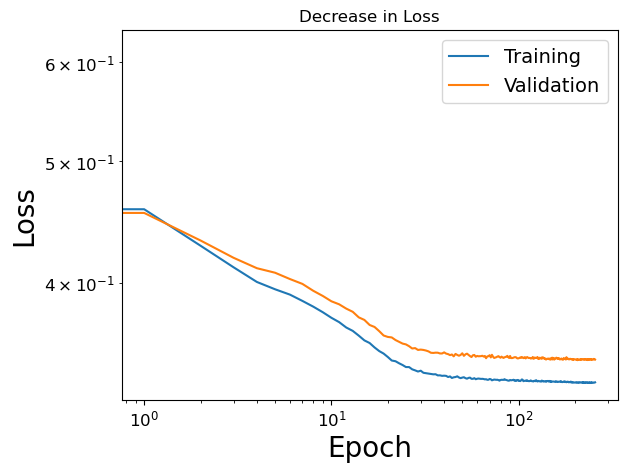

In [12]:
# plotting the decrease in loss as the network learns
fig_loss = plt.figure()
ax = fig_loss.add_subplot(111)
ax.loglog(fitting_output.history['loss'], label='Training')
ax.plot(fitting_output.history['val_loss'], label='Validation')
ax.set_title('Decrease in Loss')
ax.set_ylabel('Loss', fontsize=20)
ax.set_xlabel('Epoch', fontsize=20)
ax.legend(loc='upper right', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
# ax.set_xticks(np.arange(0, epochs, 1))
#ax.set_ylim(0, 0.3)
plt.show()

## testing the model

In [13]:
# compare autoencoder model to encoder and decoder models

f1 = autoencoder.predict([x_test, rtimes_te])
f2 = decoder(np.concatenate((encoder(x_test)[2].numpy(), rtimes_te), axis=1))

63/63 [==============================] - 0s 2ms/step


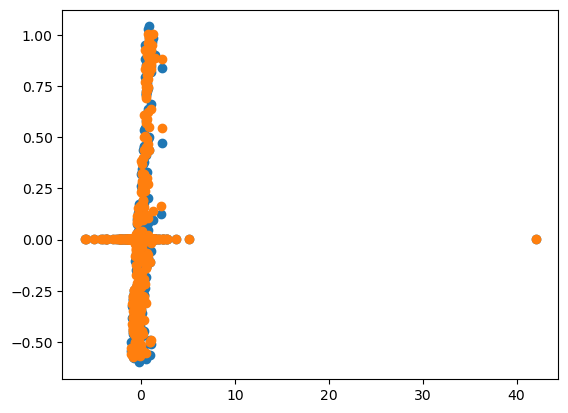

In [14]:
plt.plot(answers_te, f1, 'o')
plt.plot(answers_te, f2, 'o')

In [15]:
encoded_data = encoder(x_test)[2]

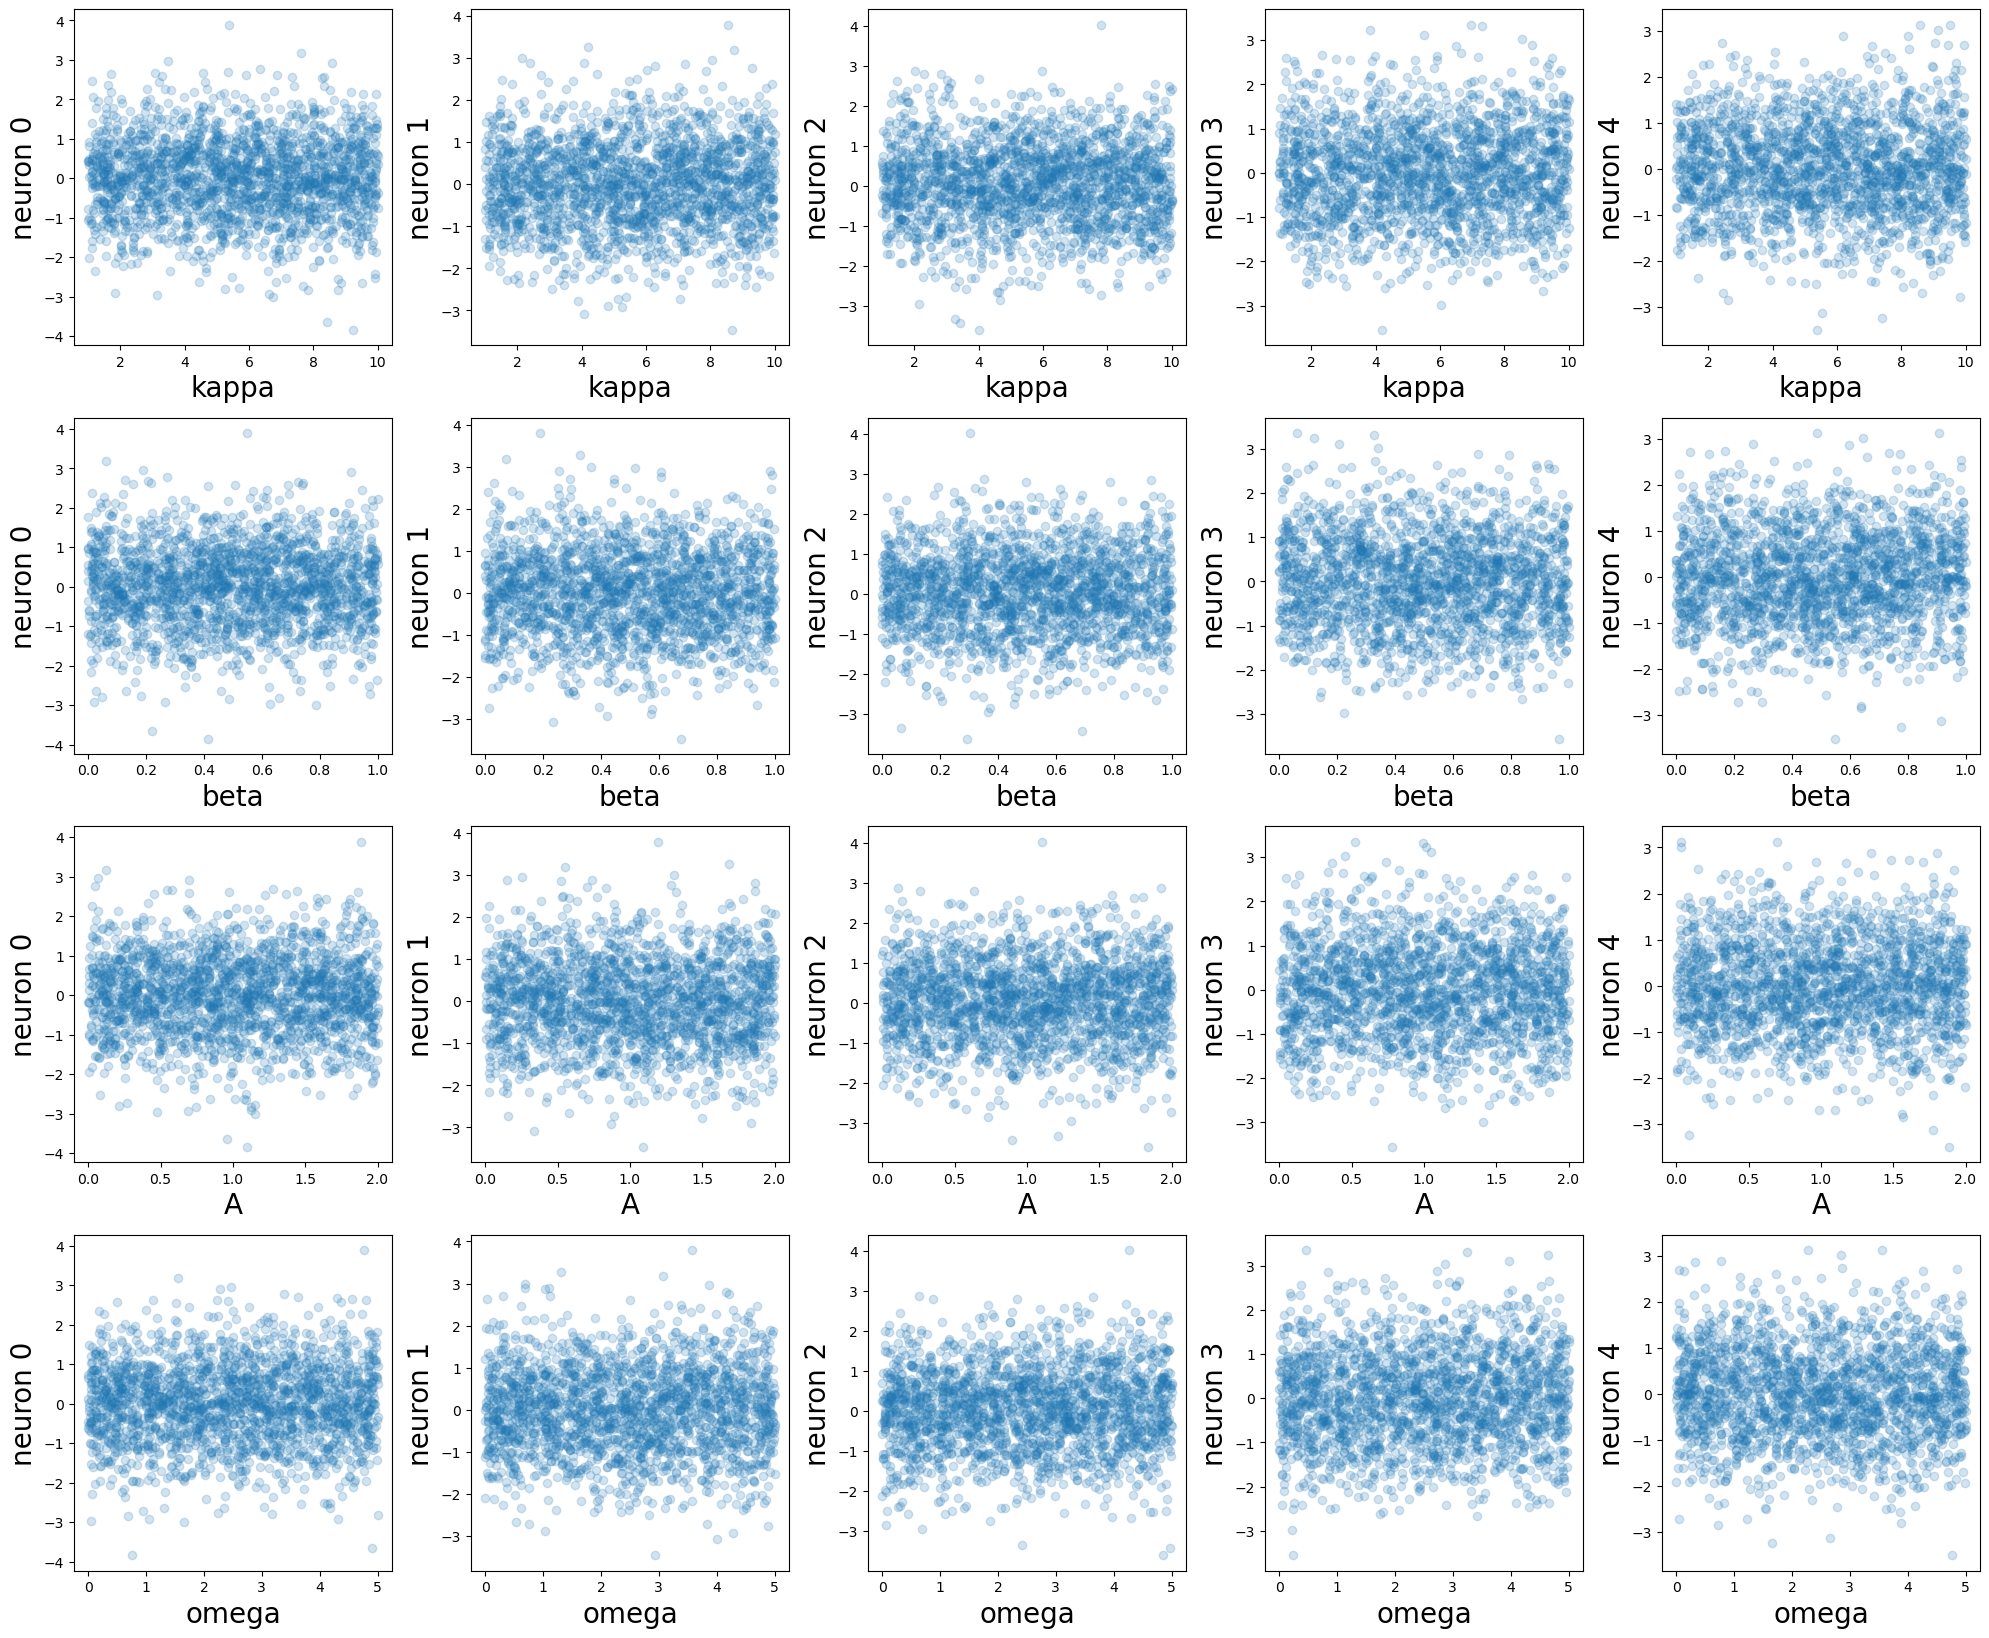

In [16]:
fig = plt.figure(figsize=(20, 20))

fontsize = 20

# Kappa plots
ax1 = fig.add_subplot(551)
ax1.plot(kappas_te, encoded_data[:, 0], 'o', alpha=0.2)
ax1.set_xlabel('kappa', fontsize=fontsize)
ax1.set_ylabel('neuron 0', fontsize=fontsize)

ax2 = fig.add_subplot(552)
ax2.plot(kappas_te, encoded_data[:, 1], 'o', alpha=0.2)
ax2.set_xlabel('kappa', fontsize=fontsize)
ax2.set_ylabel('neuron 1', fontsize=fontsize)

ax3 = fig.add_subplot(553)
ax3.plot(kappas_te, encoded_data[:, 2], 'o', alpha=0.2)
ax3.set_xlabel('kappa', fontsize=fontsize)
ax3.set_ylabel('neuron 2', fontsize=fontsize)

ax4 = fig.add_subplot(554)
ax4.plot(kappas_te, encoded_data[:, 3], 'o', alpha=0.2)
ax4.set_xlabel('kappa', fontsize=fontsize)
ax4.set_ylabel('neuron 3', fontsize=fontsize)

ax5 = fig.add_subplot(555)
ax5.plot(kappas_te, encoded_data[:, 4], 'o', alpha=0.2)
ax5.set_xlabel('kappa', fontsize=fontsize)
ax5.set_ylabel('neuron 4', fontsize=fontsize)

# Beta plots
ax6 = fig.add_subplot(556)
ax6.plot(betas_te, encoded_data[:, 0], 'o', alpha=0.2)
ax6.set_xlabel('beta', fontsize=fontsize)
ax6.set_ylabel('neuron 0', fontsize=fontsize)

ax7 = fig.add_subplot(557)
ax7.plot(betas_te, encoded_data[:, 1], 'o', alpha=0.2)
ax7.set_xlabel('beta', fontsize=fontsize)
ax7.set_ylabel('neuron 1', fontsize=fontsize)

ax8 = fig.add_subplot(558)
ax8.plot(betas_te, encoded_data[:, 2], 'o', alpha=0.2)
ax8.set_xlabel('beta', fontsize=fontsize)
ax8.set_ylabel('neuron 2', fontsize=fontsize)

ax9 = fig.add_subplot(559)
ax9.plot(betas_te, encoded_data[:, 3], 'o', alpha=0.2)
ax9.set_xlabel('beta', fontsize=fontsize)
ax9.set_ylabel('neuron 3', fontsize=fontsize)

ax10 = fig.add_subplot(5, 5, 10)
ax10.plot(betas_te, encoded_data[:, 4], 'o', alpha=0.2)
ax10.set_xlabel('beta', fontsize=fontsize)
ax10.set_ylabel('neuron 4', fontsize=fontsize)

# A plots
ax11 = fig.add_subplot(5, 5, 11)
ax11.plot(As_te, encoded_data[:, 0], 'o', alpha=0.2)
ax11.set_xlabel('A', fontsize=fontsize)
ax11.set_ylabel('neuron 0', fontsize=fontsize)

ax12 = fig.add_subplot(5, 5, 12)
ax12.plot(As_te, encoded_data[:, 1], 'o', alpha=0.2)
ax12.set_xlabel('A', fontsize=fontsize)
ax12.set_ylabel('neuron 1', fontsize=fontsize)

ax13 = fig.add_subplot(5, 5, 13)
ax13.plot(As_te, encoded_data[:, 2], 'o', alpha=0.2)
ax13.set_xlabel('A', fontsize=fontsize)
ax13.set_ylabel('neuron 2', fontsize=fontsize)

ax14 = fig.add_subplot(5, 5, 14)
ax14.plot(As_te, encoded_data[:, 3], 'o', alpha=0.2)
ax14.set_xlabel('A', fontsize=fontsize)
ax14.set_ylabel('neuron 3', fontsize=fontsize)

ax15 = fig.add_subplot(5, 5, 15)
ax15.plot(As_te, encoded_data[:, 4], 'o', alpha=0.2)
ax15.set_xlabel('A', fontsize=fontsize)
ax15.set_ylabel('neuron 4', fontsize=fontsize)

# Omega plots
ax16 = fig.add_subplot(5, 5, 16)
ax16.plot(omegas_te, encoded_data[:, 0], 'o', alpha=0.2)
ax16.set_xlabel('omega', fontsize=fontsize)
ax16.set_ylabel('neuron 0', fontsize=fontsize)

ax17 = fig.add_subplot(5, 5, 17)
ax17.plot(omegas_te, encoded_data[:, 1], 'o', alpha=0.2)
ax17.set_xlabel('omega', fontsize=fontsize)
ax17.set_ylabel('neuron 1', fontsize=fontsize)

ax18 = fig.add_subplot(5, 5, 18)
ax18.plot(omegas_te, encoded_data[:, 2], 'o', alpha=0.2)
ax18.set_xlabel('omega', fontsize=fontsize)
ax18.set_ylabel('neuron 2', fontsize=fontsize)

ax19 = fig.add_subplot(5, 5, 19)
ax19.plot(omegas_te, encoded_data[:, 3], 'o', alpha=0.2)
ax19.set_xlabel('omega', fontsize=fontsize)
ax19.set_ylabel('neuron 3', fontsize=fontsize)

ax20 = fig.add_subplot(5, 5, 20)
ax20.plot(omegas_te, encoded_data[:, 4], 'o', alpha=0.2)
ax20.set_xlabel('omega', fontsize=fontsize)
ax20.set_ylabel('neuron 4', fontsize=fontsize)

plt.tight_layout()

graphs_file_path = f"q_b:{batch_size}_lr:{learning_rate}_r:{regul}_r2:{regul2}"
plt.savefig(f"{graphs_file_path}.png")
plt.show()
plt.close(fig)

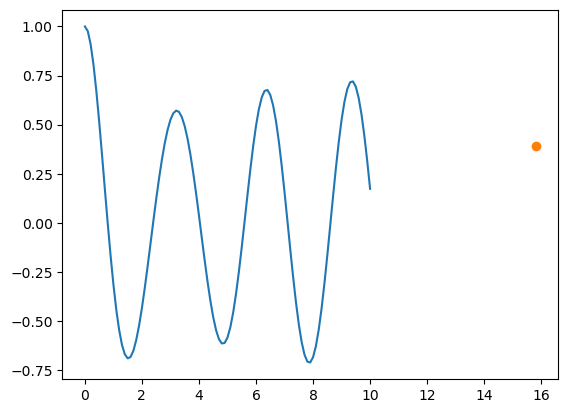

In [17]:
t = np.linspace(0, 10, 101)
plt.plot(t, x_train[9])
plt.plot(rtimes_tr[9], answers_tr[9], 'o')